In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerLine2D
# import json
from pylab import figure
import ast
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from dtw import dtw
import functools
import math
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [40]:
def load_dataframe(filepath):
    data = pd.read_csv(filepath, sep=", ", header=None)
    data[0] = data[0].apply(lambda x: x.replace("[(", ""))
    data[2] = data[2].apply(lambda x: x.replace(")", ""))
    data[3] = data[3].apply(lambda x: x.replace("(", ""))
    data[5] = data[5].apply(lambda x: x.replace(")]", ""))
    for i in range(len(data.columns)):
        data[i] = data[i].apply(lambda x: int(x))
    data.columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']
    return data 

In [41]:
load_dataframe('P1-BT/back-1.txt')

/Users/tomasero/Library/Mobile Documents/com~apple~CloudDocs/Documents/MIT/Fall18/research/exoear/byte.it/GestureiOSData/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,accX,accY,accZ,gyrX,gyrY,gyrZ
0,-15530,-1834,-5055,-28,187,9
1,-15524,-1856,-5060,-1,144,15
2,-15522,-1856,-5070,-48,158,-30
3,-15522,-1856,-5070,-48,158,-30
4,-15522,-1856,-5070,-48,158,-30
5,-15522,-1856,-5070,-48,158,-30
6,-15522,-1856,-5070,-48,158,-30
7,-15532,-1887,-5120,-28,115,-28
8,-15532,-1887,-5120,-28,115,-28
9,-15532,-1887,-5120,-28,115,-28


In [42]:
def create_single_row_df(df):
    df1=df.stack().swaplevel()
    df1.index=df1.index.map('{0[0]}_{0[1]}'.format) 
    df_new = df1.to_frame().T
    c = df_new.shape[1] + 1
    while c <= 2880: # 480 * 6
        df_new[c] = np.nan
        c += 1     
    return df_new

In [43]:
# edit this as per the file name 
labels = {'LT': 1, 'RT': 2, 'BFS': 3, 'LRS': 4, 'RLS': 5, 'FBS': 6}

In [44]:
def gesture_overall_dataframe(root_dir, label):
    final_df = pd.DataFrame()
    label_df = pd.DataFrame()
    for fname in os.listdir(root_dir):
        if fname == '.DS_Store':
            continue
        filepath = os.path.join(root_dir, fname)
        df = create_single_row_df(load_dataframe(filepath))
        df['label'] = label
        #dataframes.append(df)
        final_df = final_df.append(pd.DataFrame(df.values.tolist()), ignore_index=True)
    #dataframe = pd.concat([each for each in dataframes],ignore_index=True)    
    return final_df

In [45]:
p1_back = gesture_overall_dataframe('P1-BT', 1)
p1_back

/Users/tomasero/Library/Mobile Documents/com~apple~CloudDocs/Documents/MIT/Fall18/research/exoear/byte.it/GestureiOSData/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,-15568.0,-1626.0,-5116.0,-71.0,214.0,7.0,-15570.0,-1642.0,-5151.0,-83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,-15582.0,-1563.0,-5154.0,-57.0,188.0,24.0,-15580.0,-1548.0,-5112.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,-15564.0,-1876.0,-4929.0,-57.0,200.0,41.0,-15556.0,-1862.0,-4955.0,-61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,-15530.0,-1834.0,-5055.0,-28.0,187.0,9.0,-15524.0,-1856.0,-5060.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,-15551.0,-1857.0,-5146.0,-36.0,187.0,38.0,-15544.0,-1864.0,-5132.0,-34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,-15464.0,-1877.0,-5400.0,41.0,82.0,6.0,-15477.0,-1892.0,-5306.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,-15547.0,-1768.0,-5113.0,-59.0,177.0,21.0,-15548.0,-1738.0,-5133.0,-123.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7,-15552.0,-1541.0,-5167.0,-4.0,157.0,50.0,-15553.0,-1526.0,-5180.0,-5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,-15514.0,-1816.0,-5203.0,-40.0,165.0,-2.0,-15525.0,-1820.0,-5213.0,-39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,-15511.0,-1768.0,-5193.0,-110.0,161.0,15.0,-15504.0,-1770.0,-5179.0,-78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [46]:
p1_left = gesture_overall_dataframe('P1-LT', 2)
p1_left

/Users/tomasero/Library/Mobile Documents/com~apple~CloudDocs/Documents/MIT/Fall18/research/exoear/byte.it/GestureiOSData/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,-15467.0,-1690.0,-5291.0,-56.0,197.0,-59.0,-15451.0,-1658.0,-5368.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,-15502.0,-1798.0,-5434.0,-3.0,218.0,12.0,-15489.0,-1805.0,-5428.0,-41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,-15468.0,-1764.0,-5499.0,-79.0,177.0,3.0,-15429.0,-1747.0,-5539.0,-427.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,-15480.0,-1687.0,-5355.0,-16.0,210.0,43.0,-15511.0,-1680.0,-5364.0,-32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,-15507.0,-1755.0,-5316.0,-91.0,163.0,5.0,-15506.0,-1755.0,-5313.0,-4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
5,-15461.0,-1920.0,-5309.0,-142.0,214.0,10.0,-15458.0,-1902.0,-5320.0,-53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
6,-15447.0,-1844.0,-5349.0,-95.0,154.0,44.0,-15453.0,-1813.0,-5346.0,-101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
7,-15438.0,-1824.0,-5517.0,-29.0,169.0,48.0,-15427.0,-1808.0,-5499.0,-71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
8,-15619.0,-1541.0,-4819.0,-145.0,238.0,77.0,-15637.0,-1552.0,-4861.0,-259.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
9,-15517.0,-1677.0,-5351.0,-129.0,204.0,37.0,-15536.0,-1750.0,-5377.0,-148.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [47]:
p1_right = gesture_overall_dataframe('P1-RT', 3)
p1_right

/Users/tomasero/Library/Mobile Documents/com~apple~CloudDocs/Documents/MIT/Fall18/research/exoear/byte.it/GestureiOSData/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,-15654.0,-435.0,-5041.0,-60.0,146.0,-42.0,-15623.0,-472.0,-5072.0,-10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,-15668.0,-364.0,-5136.0,-88.0,171.0,15.0,-15661.0,-368.0,-5147.0,-62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,-15616.0,-376.0,-5189.0,-23.0,64.0,1.0,-15652.0,-352.0,-5173.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,-15659.0,-416.0,-5098.0,-101.0,154.0,28.0,-15668.0,-408.0,-5062.0,-7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,-15604.0,-447.0,-5045.0,-135.0,201.0,-37.0,-15632.0,-459.0,-5067.0,-84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
5,-15598.0,-403.0,-5139.0,-102.0,30.0,35.0,-15614.0,-416.0,-5146.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
6,-15667.0,-336.0,-5056.0,34.0,122.0,52.0,-15652.0,-344.0,-5024.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
7,-15657.0,-342.0,-5071.0,5.0,160.0,31.0,-15651.0,-343.0,-5059.0,203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
8,-15678.0,-434.0,-5122.0,111.0,124.0,17.0,-15678.0,-436.0,-5067.0,373.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
9,-15633.0,-344.0,-5032.0,12.0,110.0,2.0,-15635.0,-368.0,-5000.0,488.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [48]:
p1_front = gesture_overall_dataframe('P1-FT', 4)
p1_front

/Users/tomasero/Library/Mobile Documents/com~apple~CloudDocs/Documents/MIT/Fall18/research/exoear/byte.it/GestureiOSData/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,-15642.0,-1375.0,-4747.0,-95.0,160.0,-11.0,-15623.0,-1388.0,-4764.0,-67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
1,-15620.0,-1364.0,-4824.0,-69.0,155.0,45.0,-15604.0,-1355.0,-4834.0,-81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,-15681.0,-1326.0,-4669.0,-31.0,199.0,14.0,-15700.0,-1340.0,-4661.0,-49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
3,-15663.0,-1353.0,-4696.0,-96.0,168.0,27.0,-15664.0,-1336.0,-4701.0,-142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
4,-15664.0,-1360.0,-4742.0,-61.0,190.0,32.0,-15663.0,-1393.0,-4724.0,-114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
5,-15655.0,-1384.0,-4780.0,-118.0,183.0,5.0,-15646.0,-1384.0,-4751.0,-89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
6,-15657.0,-1393.0,-4760.0,-38.0,183.0,-7.0,-15665.0,-1378.0,-4753.0,-82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
7,-15644.0,-1411.0,-4770.0,-68.0,175.0,7.0,-15643.0,-1411.0,-4768.0,-43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
8,-15637.0,-1356.0,-4673.0,-108.0,98.0,60.0,-15610.0,-1313.0,-4666.0,-150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
9,-15654.0,-1420.0,-4712.0,-114.0,117.0,-4.0,-15669.0,-1405.0,-4708.0,-71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0


In [49]:
p1_lrs = gesture_overall_dataframe('P1-RLS', 100)
p1_lrs

/Users/tomasero/Library/Mobile Documents/com~apple~CloudDocs/Documents/MIT/Fall18/research/exoear/byte.it/GestureiOSData/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,-15976.0,-575.0,-3058.0,278.0,69.0,68.0,-15985.0,-580.0,-3038.0,182.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
1,-15745.0,-1986.0,-3764.0,310.0,51.0,35.0,-15754.0,-1984.0,-3721.0,327.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
2,-15819.0,-1556.0,-3699.0,-148.0,166.0,-15.0,-15811.0,-1557.0,-3696.0,-132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
3,-15805.0,-1672.0,-3660.0,255.0,219.0,30.0,-15801.0,-1651.0,-3685.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
4,-15824.0,-1674.0,-3682.0,180.0,125.0,53.0,-15814.0,-1692.0,-3718.0,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
5,-15852.0,-1516.0,-3545.0,271.0,9.0,61.0,-15820.0,-1574.0,-3518.0,319.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
6,-15820.0,-1585.0,-3612.0,226.0,152.0,65.0,-15823.0,-1612.0,-3613.0,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
7,-15854.0,-1667.0,-3704.0,370.0,102.0,15.0,-15831.0,-1686.0,-3650.0,263.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
8,-15804.0,-1560.0,-3631.0,33.0,184.0,9.0,-15835.0,-1488.0,-3667.0,210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
9,-15879.0,-1352.0,-3566.0,-4.0,98.0,17.0,-15904.0,-1353.0,-3525.0,363.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0


In [52]:
def get_dataframe_for_each_participant(participant_number):
    dfs = []
    for l in labels:
        gesture_name = participant_number + "-" + l
        # Temporary adjustment 
        if (gesture_name == 'P4-LRS') or (gesture_name == 'P4-RLS'):
            continue
        dfs.append(gesture_overall_dataframe(gesture_name, labels[l]))
    df =  pd.concat([each for each in dfs],ignore_index=True)      
    return df

In [53]:
get_dataframe_for_each_participant("P1") #P1, P2, P8, 

/Users/tomasero/Library/Mobile Documents/com~apple~CloudDocs/Documents/MIT/Fall18/research/exoear/byte.it/GestureiOSData/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,-15467.0,-1690.0,-5291.0,-56.0,197.0,-59.0,-15451.0,-1658.0,-5368.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,-15502.0,-1798.0,-5434.0,-3.0,218.0,12.0,-15489.0,-1805.0,-5428.0,-41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,-15468.0,-1764.0,-5499.0,-79.0,177.0,3.0,-15429.0,-1747.0,-5539.0,-427.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,-15480.0,-1687.0,-5355.0,-16.0,210.0,43.0,-15511.0,-1680.0,-5364.0,-32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,-15507.0,-1755.0,-5316.0,-91.0,163.0,5.0,-15506.0,-1755.0,-5313.0,-4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,-15461.0,-1920.0,-5309.0,-142.0,214.0,10.0,-15458.0,-1902.0,-5320.0,-53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,-15447.0,-1844.0,-5349.0,-95.0,154.0,44.0,-15453.0,-1813.0,-5346.0,-101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7,-15438.0,-1824.0,-5517.0,-29.0,169.0,48.0,-15427.0,-1808.0,-5499.0,-71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,-15619.0,-1541.0,-4819.0,-145.0,238.0,77.0,-15637.0,-1552.0,-4861.0,-259.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,-15517.0,-1677.0,-5351.0,-129.0,204.0,37.0,-15536.0,-1750.0,-5377.0,-148.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [54]:
# get_dataframe_for_each_participant("P3")

In [55]:
def get_dataframe_for_all_participants():
    particiapnts = ['P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12']#['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12']
    dfs = []
    for p in particiapnts:
        dfs.append(get_dataframe_for_each_participant(p))
    df = pd.concat([each for each in dfs],ignore_index=True)      
    return df        

In [56]:
sample_dataframe = get_dataframe_for_all_participants()
sample_dataframe

/Users/tomasero/Library/Mobile Documents/com~apple~CloudDocs/Documents/MIT/Fall18/research/exoear/byte.it/GestureiOSData/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,-14869.0,5802.0,-3708.0,-121.0,231.0,25.0,-14889.0,5782.0,-3724.0,-95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,-14989.0,5613.0,-3585.0,-178.0,406.0,50.0,-14997.0,5632.0,-3629.0,-174.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,-15053.0,5546.0,-3842.0,-145.0,277.0,-5.0,-14978.0,5571.0,-3856.0,-116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,-15141.0,5308.0,-3198.0,-78.0,221.0,50.0,-15149.0,5294.0,-3196.0,-51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,-15230.0,5092.0,-3185.0,-96.0,204.0,21.0,-15227.0,5092.0,-3154.0,-91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,-15244.0,5152.0,-2979.0,-372.0,547.0,15.0,-15227.0,5114.0,-3076.0,-347.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,-15318.0,4784.0,-3141.0,-128.0,237.0,61.0,-15317.0,4824.0,-3180.0,-156.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7,-14994.0,5512.0,-4044.0,-18.0,217.0,-106.0,-14924.0,5485.0,-4105.0,-203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,-15028.0,5440.0,-3842.0,-92.0,201.0,13.0,-15036.0,5444.0,-3852.0,-97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,-14885.0,5783.0,-3837.0,-70.0,170.0,15.0,-14885.0,5804.0,-3802.0,-63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [57]:
bb = sample_dataframe.iloc[[0],:-1]
bb

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
0,-14869.0,5802.0,-3708.0,-121.0,231.0,25.0,-14889.0,5782.0,-3724.0,-95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
bb_c = pd.DataFrame(bb.values.reshape(480,-1),
                      index=bb.index.repeat(480))

In [59]:
bb_c

,0,1,2,3,4,5
0,-14869.0,5802.0,-3708.0,-121.0,231.0,25.0
0,-14889.0,5782.0,-3724.0,-95.0,184.0,-17.0
0,-14889.0,5782.0,-3724.0,-95.0,184.0,-17.0
0,-14889.0,5782.0,-3724.0,-95.0,184.0,-17.0
0,-14897.0,5779.0,-3723.0,-30.0,165.0,-63.0
0,-14897.0,5779.0,-3723.0,-30.0,165.0,-63.0
0,-14897.0,5779.0,-3723.0,-30.0,165.0,-63.0
0,-14897.0,5779.0,-3723.0,-30.0,165.0,-63.0
0,-14897.0,5779.0,-3723.0,-30.0,165.0,-63.0
0,-14924.0,5761.0,-3737.0,-132.0,299.0,-118.0


In [60]:
bb_cc = bb_c.fillna(727199802211965)
bb_cc

,0,1,2,3,4,5
0,-1.486900e+04,5.802000e+03,-3.708000e+03,-1.210000e+02,2.310000e+02,2.500000e+01
0,-1.488900e+04,5.782000e+03,-3.724000e+03,-9.500000e+01,1.840000e+02,-1.700000e+01
0,-1.488900e+04,5.782000e+03,-3.724000e+03,-9.500000e+01,1.840000e+02,-1.700000e+01
0,-1.488900e+04,5.782000e+03,-3.724000e+03,-9.500000e+01,1.840000e+02,-1.700000e+01
0,-1.489700e+04,5.779000e+03,-3.723000e+03,-3.000000e+01,1.650000e+02,-6.300000e+01
0,-1.489700e+04,5.779000e+03,-3.723000e+03,-3.000000e+01,1.650000e+02,-6.300000e+01
0,-1.489700e+04,5.779000e+03,-3.723000e+03,-3.000000e+01,1.650000e+02,-6.300000e+01
0,-1.489700e+04,5.779000e+03,-3.723000e+03,-3.000000e+01,1.650000e+02,-6.300000e+01
0,-1.489700e+04,5.779000e+03,-3.723000e+03,-3.000000e+01,1.650000e+02,-6.300000e+01
0,-1.492400e+04,5.761000e+03,-3.737000e+03,-1.320000e+02,2.990000e+02,-1.180000e+02


In [61]:
bb_ccc = bb_cc.replace(727199802211965, np.nan).dropna()

In [62]:
bb_ccc

,0,1,2,3,4,5
0,-14869.0,5802.0,-3708.0,-121.0,231.0,25.0
0,-14889.0,5782.0,-3724.0,-95.0,184.0,-17.0
0,-14889.0,5782.0,-3724.0,-95.0,184.0,-17.0
0,-14889.0,5782.0,-3724.0,-95.0,184.0,-17.0
0,-14897.0,5779.0,-3723.0,-30.0,165.0,-63.0
0,-14897.0,5779.0,-3723.0,-30.0,165.0,-63.0
0,-14897.0,5779.0,-3723.0,-30.0,165.0,-63.0
0,-14897.0,5779.0,-3723.0,-30.0,165.0,-63.0
0,-14897.0,5779.0,-3723.0,-30.0,165.0,-63.0
0,-14924.0,5761.0,-3737.0,-132.0,299.0,-118.0


In [63]:
sad = sample_dataframe.copy()
sad

,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,-14869.0,5802.0,-3708.0,-121.0,231.0,25.0,-14889.0,5782.0,-3724.0,-95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,-14989.0,5613.0,-3585.0,-178.0,406.0,50.0,-14997.0,5632.0,-3629.0,-174.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,-15053.0,5546.0,-3842.0,-145.0,277.0,-5.0,-14978.0,5571.0,-3856.0,-116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,-15141.0,5308.0,-3198.0,-78.0,221.0,50.0,-15149.0,5294.0,-3196.0,-51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,-15230.0,5092.0,-3185.0,-96.0,204.0,21.0,-15227.0,5092.0,-3154.0,-91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,-15244.0,5152.0,-2979.0,-372.0,547.0,15.0,-15227.0,5114.0,-3076.0,-347.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,-15318.0,4784.0,-3141.0,-128.0,237.0,61.0,-15317.0,4824.0,-3180.0,-156.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
7,-14994.0,5512.0,-4044.0,-18.0,217.0,-106.0,-14924.0,5485.0,-4105.0,-203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,-15028.0,5440.0,-3842.0,-92.0,201.0,13.0,-15036.0,5444.0,-3852.0,-97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,-14885.0,5783.0,-3837.0,-70.0,170.0,15.0,-14885.0,5804.0,-3802.0,-63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [64]:
sad = sad.fillna(727199802211965)
sad

,0,1,2,3,4,5,6,7,8,9,...,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880
0,-14869.0,5802.0,-3708.0,-121.0,231.0,25.0,-14889.0,5782.0,-3724.0,-95.0,...,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,1.0
1,-14989.0,5613.0,-3585.0,-178.0,406.0,50.0,-14997.0,5632.0,-3629.0,-174.0,...,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,1.0
2,-15053.0,5546.0,-3842.0,-145.0,277.0,-5.0,-14978.0,5571.0,-3856.0,-116.0,...,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,1.0
3,-15141.0,5308.0,-3198.0,-78.0,221.0,50.0,-15149.0,5294.0,-3196.0,-51.0,...,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,1.0
4,-15230.0,5092.0,-3185.0,-96.0,204.0,21.0,-15227.0,5092.0,-3154.0,-91.0,...,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,1.0
5,-15244.0,5152.0,-2979.0,-372.0,547.0,15.0,-15227.0,5114.0,-3076.0,-347.0,...,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,1.0
6,-15318.0,4784.0,-3141.0,-128.0,237.0,61.0,-15317.0,4824.0,-3180.0,-156.0,...,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,1.0
7,-14994.0,5512.0,-4044.0,-18.0,217.0,-106.0,-14924.0,5485.0,-4105.0,-203.0,...,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,1.0
8,-15028.0,5440.0,-3842.0,-92.0,201.0,13.0,-15036.0,5444.0,-3852.0,-97.0,...,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,1.0
9,-14885.0,5783.0,-3837.0,-70.0,170.0,15.0,-14885.0,5804.0,-3802.0,-63.0,...,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,7.271998e+14,1.0


In [65]:
ddd = pd.DataFrame(sad.iloc[[0],:-1].values)
pd.DataFrame(ddd.values.reshape(480,-1),
                      index=ddd.index.repeat(480))

,0,1,2,3,4,5
0,-1.486900e+04,5.802000e+03,-3.708000e+03,-1.210000e+02,2.310000e+02,2.500000e+01
0,-1.488900e+04,5.782000e+03,-3.724000e+03,-9.500000e+01,1.840000e+02,-1.700000e+01
0,-1.488900e+04,5.782000e+03,-3.724000e+03,-9.500000e+01,1.840000e+02,-1.700000e+01
0,-1.488900e+04,5.782000e+03,-3.724000e+03,-9.500000e+01,1.840000e+02,-1.700000e+01
0,-1.489700e+04,5.779000e+03,-3.723000e+03,-3.000000e+01,1.650000e+02,-6.300000e+01
0,-1.489700e+04,5.779000e+03,-3.723000e+03,-3.000000e+01,1.650000e+02,-6.300000e+01
0,-1.489700e+04,5.779000e+03,-3.723000e+03,-3.000000e+01,1.650000e+02,-6.300000e+01
0,-1.489700e+04,5.779000e+03,-3.723000e+03,-3.000000e+01,1.650000e+02,-6.300000e+01
0,-1.489700e+04,5.779000e+03,-3.723000e+03,-3.000000e+01,1.650000e+02,-6.300000e+01
0,-1.492400e+04,5.761000e+03,-3.737000e+03,-1.320000e+02,2.990000e+02,-1.180000e+02


In [66]:
def get_dataframe_column_for_comparison(df):
    df = pd.DataFrame(df).T
    dfc = pd.DataFrame(df.values.reshape(480,-1),
                      index=df.index.repeat(480))
    dfc = dfc.replace(727199802211965, np.nan).dropna()
    return dfc.values

In [67]:
def run_dtw(df1, df2):
    dist, cost, acc, path = dtw(get_dataframe_column_for_comparison(df1), get_dataframe_column_for_comparison(df2), dist=lambda x, y: norm(x - y, ord=1))
    return dist

In [68]:
X = sad.iloc[:, :-1].values#sample_dataframe.iloc[:, :-1].values
y = sad.iloc[:, -1].values#sample_dataframe.iloc[:, -1].values

In [69]:
X

array([[-1.48690000e+04,  5.80200000e+03, -3.70800000e+03, ...,
         7.27199802e+14,  7.27199802e+14,  7.27199802e+14],
       [-1.49890000e+04,  5.61300000e+03, -3.58500000e+03, ...,
         7.27199802e+14,  7.27199802e+14,  7.27199802e+14],
       [-1.50530000e+04,  5.54600000e+03, -3.84200000e+03, ...,
         7.27199802e+14,  7.27199802e+14,  7.27199802e+14],
       ...,
       [-1.55000000e+04,  1.60300000e+03, -5.53200000e+03, ...,
         7.27199802e+14,  7.27199802e+14,  7.27199802e+14],
       [-1.55040000e+04,  1.52900000e+03, -5.52000000e+03, ...,
         7.27199802e+14,  7.27199802e+14,  7.27199802e+14],
       [-1.54560000e+04,  1.88900000e+03, -5.44800000e+03, ...,
         7.27199802e+14,  7.27199802e+14,  7.27199802e+14]])

In [70]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5.,
       5., 5., 5., 5., 5.

In [71]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

In [72]:
knn = KNeighborsClassifier(n_neighbors=1, metric=run_dtw)

In [73]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function run_dtw at 0x12f86b510>, metric_params=None,
           n_jobs=None, n_neighbors=1, p=2, weights='uniform')

In [74]:
# train_accuracy[i] = knn.score(X_train, y_train)

In [75]:
#Compute accuracy on the test set
# test_accuracy[i] = knn.score(X_test, y_test) 

In [76]:
y_pred= knn.predict(X_test)

In [77]:
accuracy_score(y_pred,y_test)

0.8854166666666666

In [78]:
print("Precision: {}%".format(100*precision_score(y_test, y_pred, average="weighted")))
print("Recall: {}%".format(100*recall_score(y_test, y_pred, average="weighted")))
print("f1_score: {}%".format(100*f1_score(y_test, y_pred, average="weighted")))

Precision: 89.12361846932158%
Recall: 88.54166666666666%
f1_score: 88.54634991153486%


In [79]:
print("")
print("Confusion Matrix:")
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


Confusion Matrix:
[[31  0  1  0  0  1]
 [ 2 28  1  1  0  2]
 [ 0  3 29  1  0  0]
 [ 2  0  0 28  0  0]
 [ 1  0  1  0 24  4]
 [ 0  2  0  0  0 30]]


In [81]:
# edit this as per the file name 
LABELS = ['LT', 'RT', 'BFS', 'LRS', 'RLS', 'FBS']

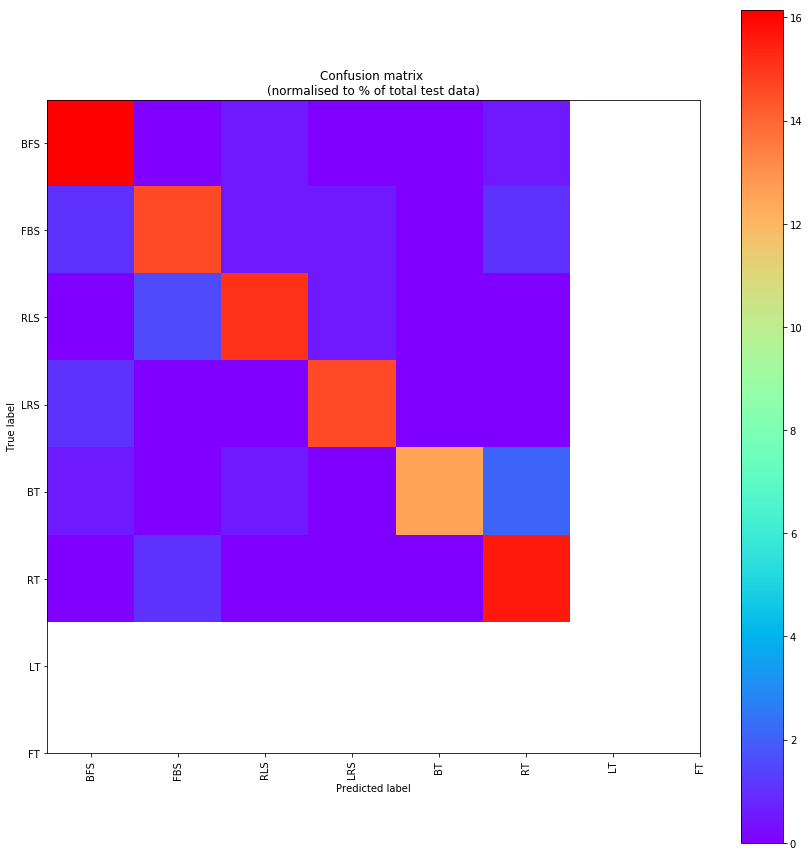

In [82]:
# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(8)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('cf_matrix')
plt.show()

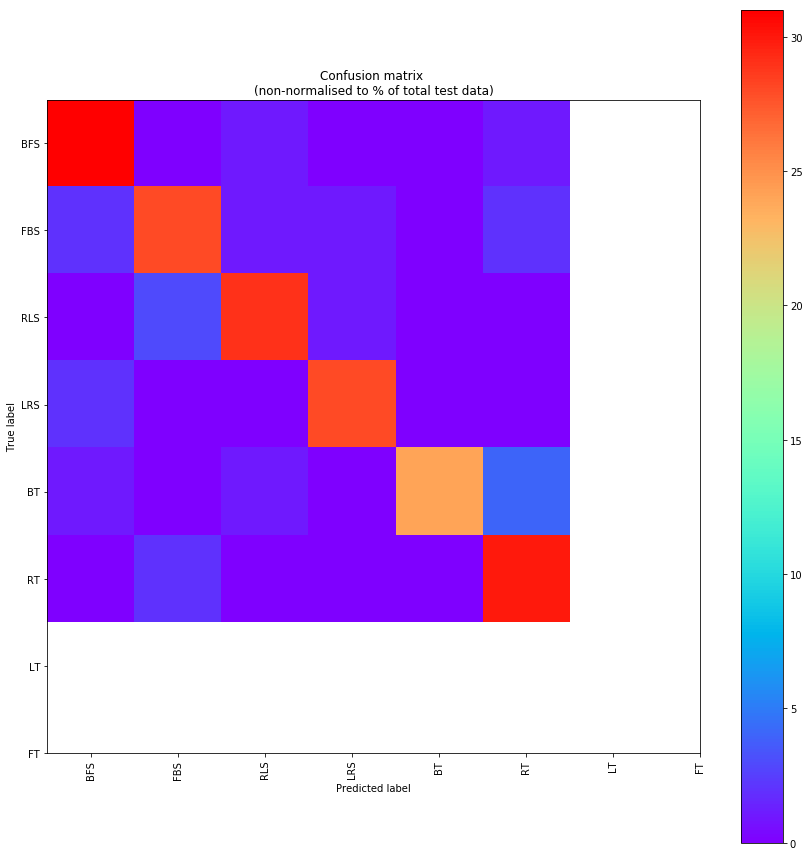

In [83]:
# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(non-normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(8)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig('cf_matrix')
plt.show()

In [84]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[31  0  1  0  0  1]
 [ 2 28  1  1  0  2]
 [ 0  3 29  1  0  0]
 [ 2  0  0 28  0  0]
 [ 1  0  1  0 24  4]
 [ 0  2  0  0  0 30]]


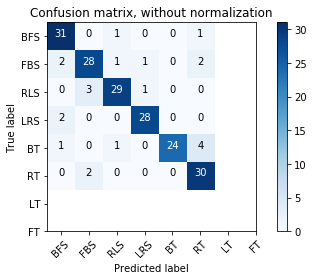

In [85]:
# Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=LABELS,
                      title='Confusion matrix, without normalization')

In [86]:
# scores = cross_val_score(knn, X, y, cv=54)

In [87]:
# scores

In [88]:
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))